<a href="https://colab.research.google.com/github/Monika171/Machine-Learning-with-Python/blob/main/python_gbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('python-gbm')
jovian.set_colab_id('1wd-vmHO3AX_67gKz45F0X2eCTNc1ISKt')

# Gradient Boosting Machines (GBMs) with XGBoost

Steps:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Let's begin by installing the required libraries.

In [2]:
!pip install numpy pandas matplotlib seaborn --quiet

In [3]:
!pip install opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

## Problem Statement

Applying Gradient boosting to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View/Download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## First, downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library.

In [4]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [5]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Skipping, found downloaded files in "./rossmann-store-sales" (use force=True to force download)


In [6]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'test.csv', 'train.csv', 'store.csv']

In [7]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [8]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [9]:
ross_df.Store.value_counts()

1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

In [10]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [11]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [12]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [13]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [14]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO


### Date

First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [16]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Day'] = df.Date.dt.day
  df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [17]:
split_date(merged_df)
split_date(merged_test_df)

In [18]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [19]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [20]:
def comp_months(df):
  df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [21]:
comp_months(merged_df)
comp_months(merged_test_df)

In [22]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,81.0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


Let's view the results of the new columns we've created.

In [23]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
602327,2014-01-08,630.0,2015.0,2.0,0.0
862246,2013-05-19,1040.0,NaN,NaN,0.0
4072,2015-07-28,13990.0,NaN,NaN,0.0
335529,2014-09-16,270.0,2013.0,4.0,17.0
513001,2014-03-29,19700.0,NaN,NaN,0.0
197612,2015-02-04,27190.0,2010.0,7.0,55.0
614125,2013-12-28,580.0,2005.0,1.0,107.0
402432,2014-07-07,1270.0,2010.0,9.0,46.0
786345,2013-07-27,5350.0,NaN,NaN,0.0
787583,2013-07-25,22560.0,NaN,NaN,0.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [26]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [27]:
promo_cols(merged_df)
promo_cols(merged_test_df)

Let's view the results of the columns we've created.

In [28]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
140527,2015-03-27,0,NaN,NaN,NaN,0.000000,0
289899,2014-11-04,1,2011.0,14.0,"Jan,Apr,Jul,Oct",43.114754,0
286884,2014-11-07,0,NaN,NaN,NaN,0.000000,0
234131,2015-01-03,0,NaN,NaN,NaN,0.000000,0
242863,2014-12-25,0,NaN,NaN,NaN,0.000000,0
489598,2014-04-19,1,2010.0,13.0,"Jan,Apr,Jul,Oct",48.688525,1
790750,2013-07-23,1,2011.0,14.0,"Jan,Apr,Jul,Oct",27.672131,1
296594,2014-10-28,0,NaN,NaN,NaN,0.000000,0
352485,2014-08-29,0,NaN,NaN,NaN,0.000000,0
807735,2013-07-07,1,2012.0,48.0,"Jan,Apr,Jul,Oct",7.180328,1


The features related to competition and promotion are now much more useful.

### Input and Target Columns

Let's select the columns that we'll use for training.

In [29]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [30]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen',
              'Day', 'Month', 'Year', 'WeekOfYear', 'Promo2',
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [32]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [33]:
test_inputs = merged_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [37]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday',
                'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
                'Day', 'Month', 'Year', 'WeekOfYear']
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [38]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2642
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [39]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [40]:
max_distance = inputs.CompetitionDistance.max()

In [41]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [45]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

Let's one-hot encode categorical columns.

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [48]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [49]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [52]:
from xgboost import XGBRegressor

In [54]:
# ?XGBRegressor

In [55]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

Let's train the model using `model.fit`.

In [56]:
%%time
model.fit(X, targets)

CPU times: user 36.4 s, sys: 151 ms, total: 36.5 s
Wall time: 18.9 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [57]:
preds = model.predict(X)

In [58]:
preds

array([8394.033 , 7906.6987, 8553.148 , ...,  739.5759, 2299.7908,
       -307.6869], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [59]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
  return mean_squared_error(a, b, squared=False)

In [60]:
rmse(preds, targets)

2259.7002821970173

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [61]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline


rcParams['figure.figsize'] = 30, 30

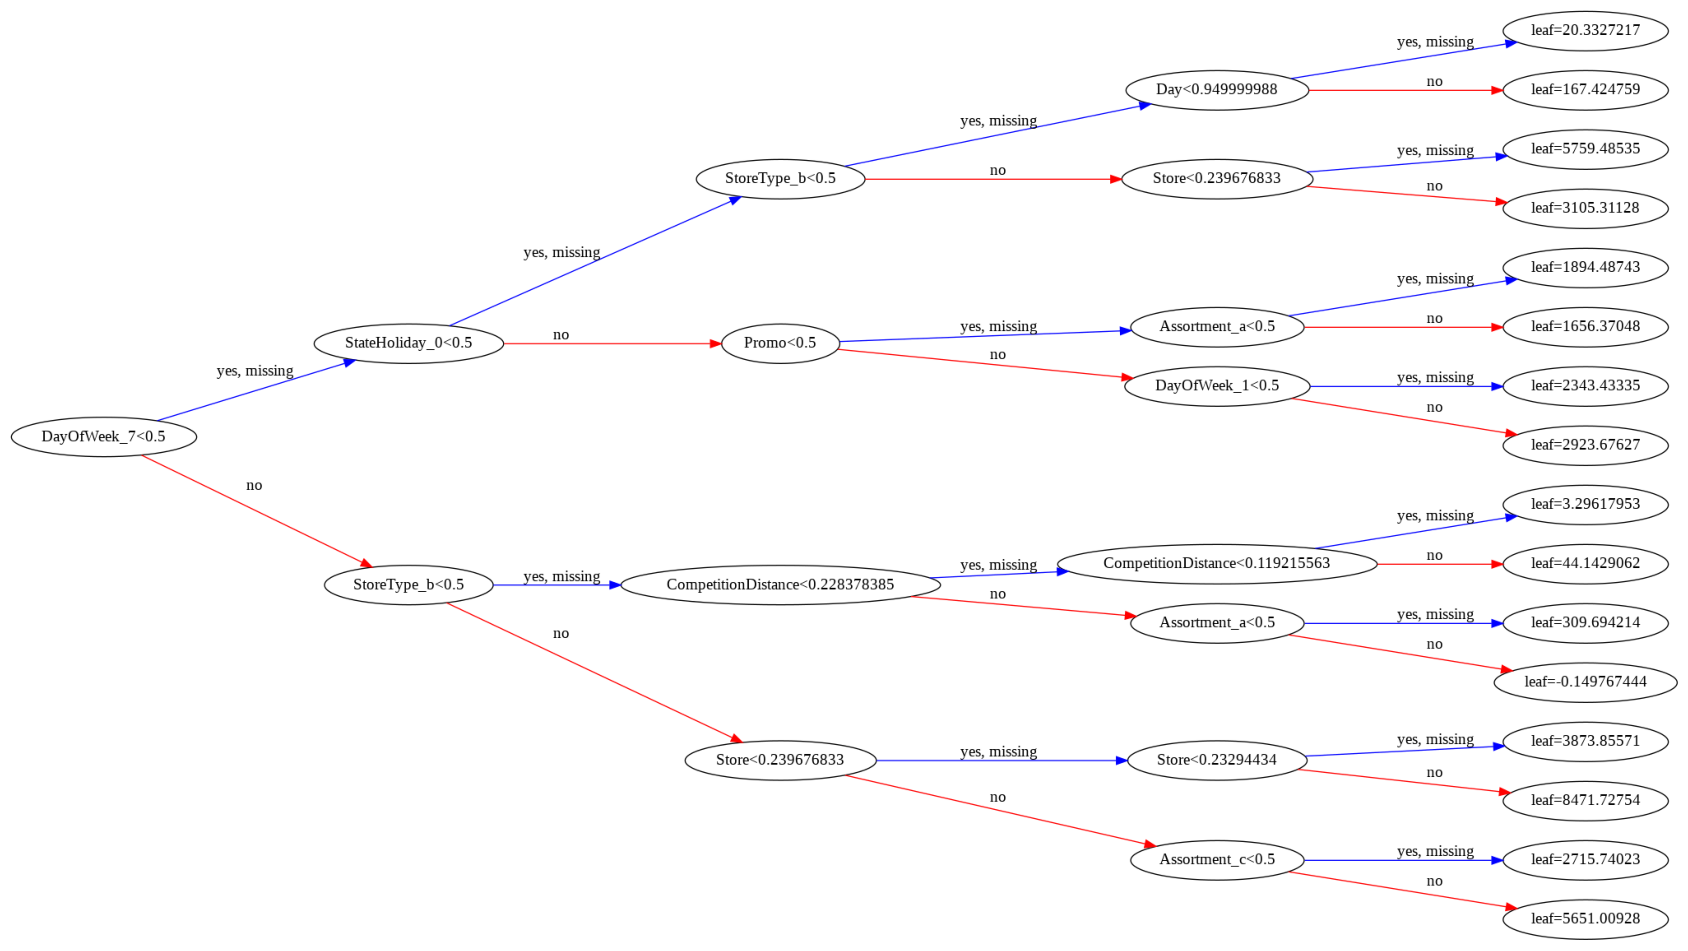

In [62]:
plot_tree(model, rankdir='LR');

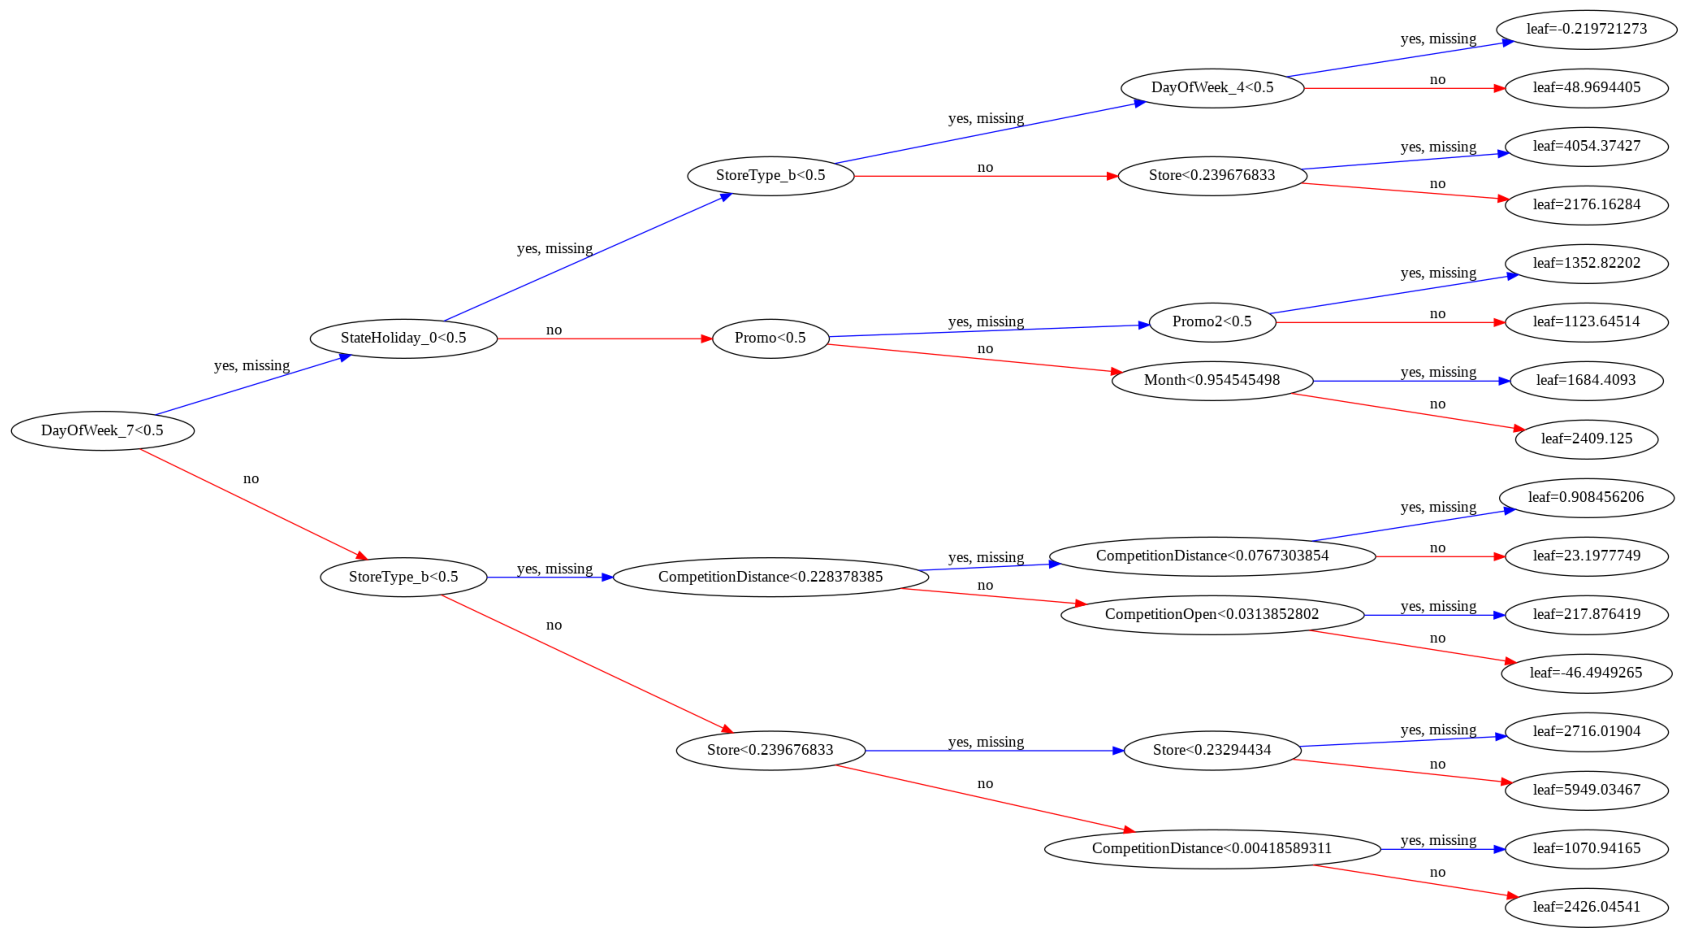

In [63]:
plot_tree(model, rankdir='LR', num_trees=1);

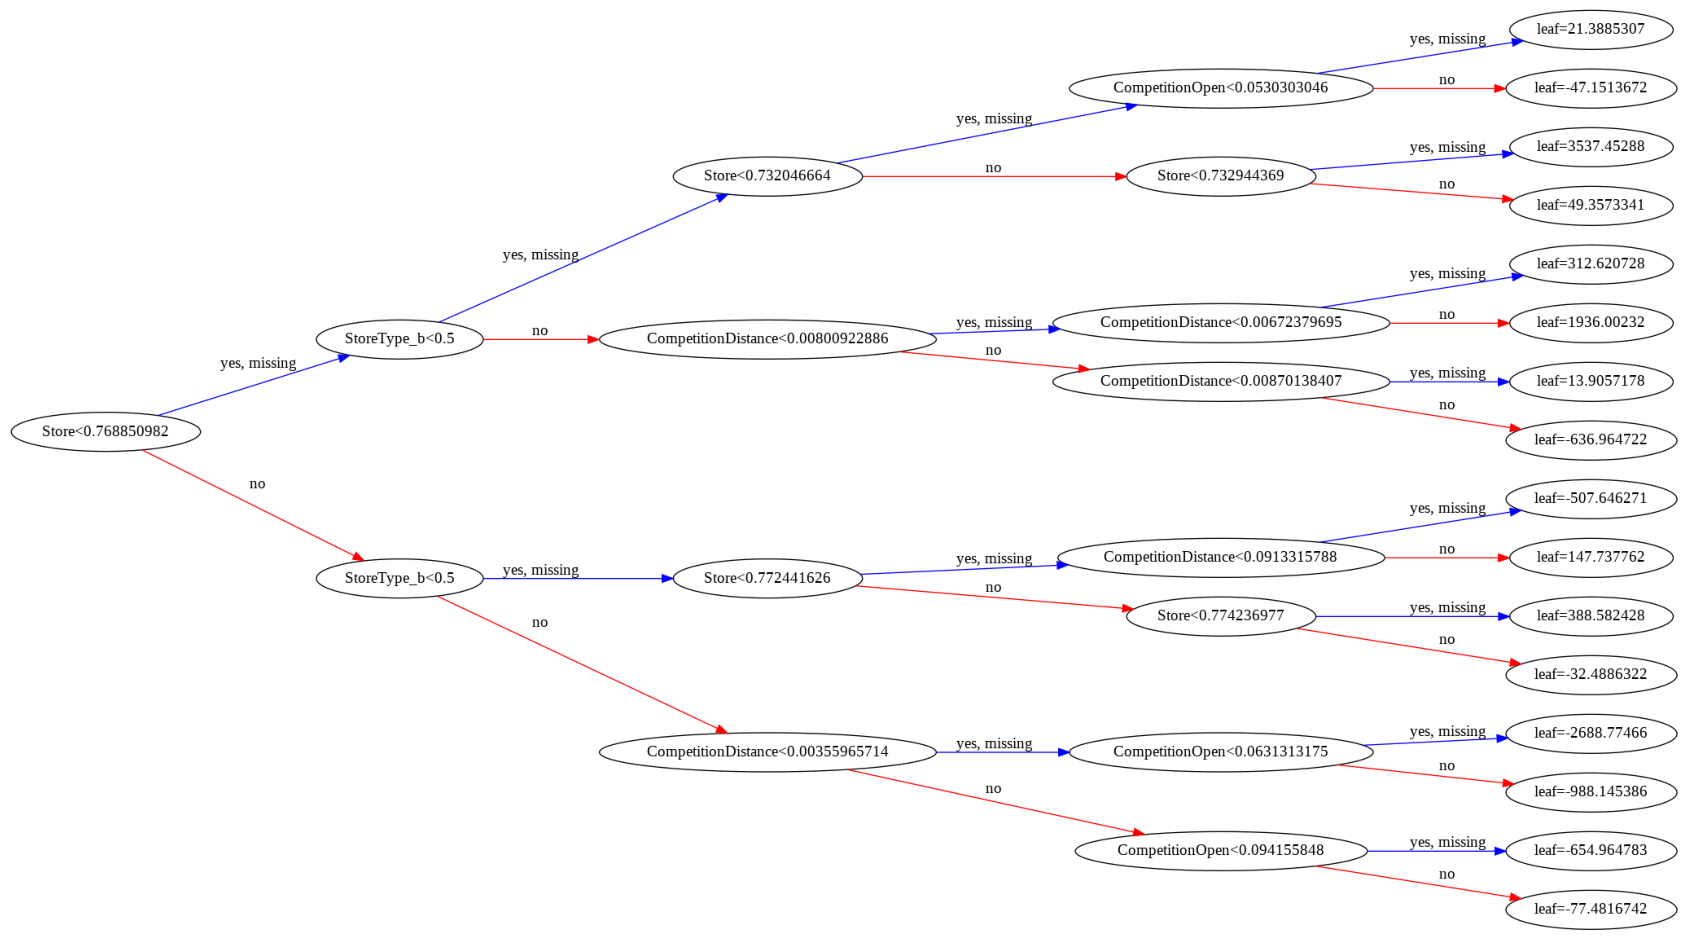

In [64]:
plot_tree(model, rankdir='LR', num_trees=19)

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [65]:
trees = model.get_booster().get_dump()

In [66]:
len(trees)

20

In [67]:
print(trees[0])

0:[DayOfWeek_7<0.5] yes=1,no=2,missing=1
	1:[StateHoliday_0<0.5] yes=3,no=4,missing=3
		3:[StoreType_b<0.5] yes=7,no=8,missing=7
			7:[Day<0.949999988] yes=15,no=16,missing=15
				15:leaf=20.3327217
				16:leaf=167.424759
			8:[Store<0.239676833] yes=17,no=18,missing=17
				17:leaf=5759.48535
				18:leaf=3105.31128
		4:[Promo<0.5] yes=9,no=10,missing=9
			9:[Assortment_a<0.5] yes=19,no=20,missing=19
				19:leaf=1894.48743
				20:leaf=1656.37048
			10:[DayOfWeek_1<0.5] yes=21,no=22,missing=21
				21:leaf=2343.43335
				22:leaf=2923.67627
	2:[StoreType_b<0.5] yes=5,no=6,missing=5
		5:[CompetitionDistance<0.228378385] yes=11,no=12,missing=11
			11:[CompetitionDistance<0.119215563] yes=23,no=24,missing=23
				23:leaf=3.29617953
				24:leaf=44.1429062
			12:[Assortment_a<0.5] yes=25,no=26,missing=25
				25:leaf=309.694214
				26:leaf=-0.149767444
		6:[Store<0.239676833] yes=13,no=14,missing=13
			13:[Store<0.23294434] yes=27,no=28,missing=27
				27:leaf=3873.85571
				28:leaf=8471.72754
			

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [68]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [69]:
importance_df.head(10)

,feature,importance
18,DayOfWeek_7,0.475862
1,Promo,0.162505
19,StateHoliday_0,0.144687
12,DayOfWeek_1,0.037895
24,StoreType_b,0.025439
5,Promo2,0.023661
27,Assortment_a,0.020641
11,WeekOfYear,0.017039
0,Store,0.013317
13,DayOfWeek_2,0.010249


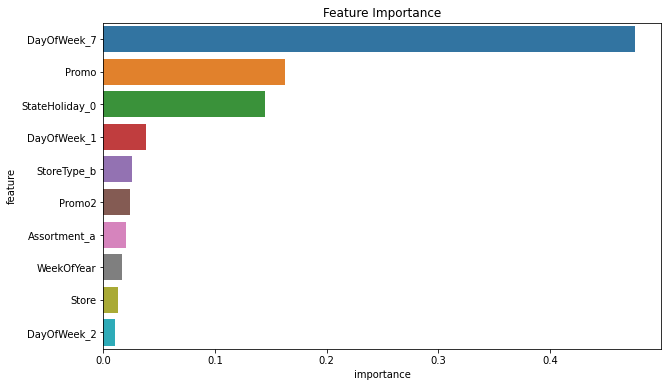

In [70]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation.

Scikit-learn provides utilities for performing K fold cross validation.

In [72]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [73]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
  model = XGBRegressor(random_state=42, n_jobs=-1, **params)
  model.fit(X_train, train_targets)
  train_rmse = rmse(model.predict(X_train), train_targets)
  val_rmse = rmse(model.predict(X_val), val_targets)
  return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [ ]:
# !pip install jovian --upgrade --quiet

In [ ]:
# import jovian

In [75]:
# Execute this to save new versions of the notebook
jovian.commit(project="python-gbm")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/monika171/python-gbm


'https://jovian.ai/monika171/python-gbm'